# Preliminaries

In [ ]:
#Specific versions in order not to incur incompatibilities issues.

!pip install transformers==4.37.2
!pip install tensorflow==2.15.1
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# System packages
import os
import sys
from urllib import request
import json

# Data and numerical management packages
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split

# Text processing
import re

# Useful during debugging (progress bars)
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# ML/DL
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K
import gc

import transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel, TFBertModel, BertModel
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling1D, MaxPooling1D, Layer
from keras.models import Model
import torch

# Hyper Parameter Tuning
import keras_tuner as kt
from keras_tuner import HyperParameters

# Interactive Environment Tools / Notebook Display Utilities
from IPython.display import display

# Analysis
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data

## Loading to a pd.DataFrame

First of all, let's load the dataset and see the first few examples.

In [ ]:
df = pd.read_json(f'https://drive.google.com/uc?id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2')

In [ ]:
print(f'Df shape: {df.shape}')
df.head()

Df shape: (4000, 5)


,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


## Analysis and Preprocessing

We will focus only on the last three columns: '`utterances`', '`emotions`', and '`triggers`'.
As follows, the analysis and the pre-processing of these three columns.

### Utterances Column

We check for `None`/`Nan` values and we plot the histogram of the frequencies of dialogues lengths.


In [ ]:
df['utterances'].explode().isna().any()

False

Along with the frequencies of the dialogues lengths, we compute the percentiles. This operation will come in handy later, in the input *encoding* section.

In [ ]:
def create_utterances_histogram(df,title):
  '''
  Create df column histogram and show pecentiles
  '''
  #Histogram frequency and bins
  lens = np.array(df.apply(len))
  bin_edges = np.arange(min(lens)-0.5, max(lens)+1.5, 1)

  # Set the plot title and labels
  plt.figure(figsize=(10, 6))
  plt.hist(lens, bins=bin_edges, edgecolor='k')
  plt.title(title)
  plt.xlabel('Length')
  plt.ylabel('Frequency')

  # Show the plot
  plt.show()

  #Percentiles
  percentiles = [25, 50, 75, 90, 95, 100]
  print("Percentile values:")
  for p in percentiles:
    print(f'{p/100} : {np.percentile(lens,p)}')

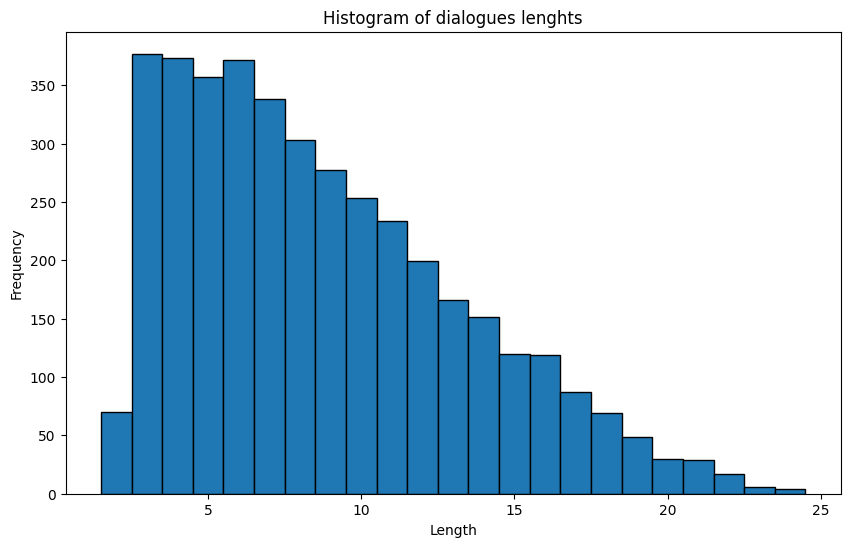

Percentile values:
0.25 : 5.0
0.5 : 8.0
0.75 : 12.0
0.9 : 16.0
0.95 : 18.0
1.0 : 24.0


In [ ]:
create_utterances_histogram(df["utterances"],"Histogram of dialogues lenghts")

We start seeing an imbalance in the distribution of dialogues lengths, with the frequency that decreases as the lengths increase.

After having considered the dialogues, we focus on the utterances. In order to go on with the analysis, we first need to tokenize our dialogues, via the `AutoTokenizer` from the `transformers` library.

In [ ]:
# Load a Bert tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

df['utterances_tokenized'] = df['utterances'].apply(lambda x: tokenizer(x)['input_ids'])
df['utterances_tokenized'].head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

,utterances_tokenized
0,"[[101, 2036, 1045, 2001, 1996, 2391, 2711, 200..."
1,"[[101, 2036, 1045, 2001, 1996, 2391, 2711, 200..."
2,"[[101, 2036, 1045, 2001, 1996, 2391, 2711, 200..."
3,"[[101, 2036, 1045, 2001, 1996, 2391, 2711, 200..."
4,"[[101, 2021, 2059, 2040, 1029, 1996, 13877, 10..."


Just as we did for dialogues, we plot the histogram of utterances lengths, along with computing the percentiles.

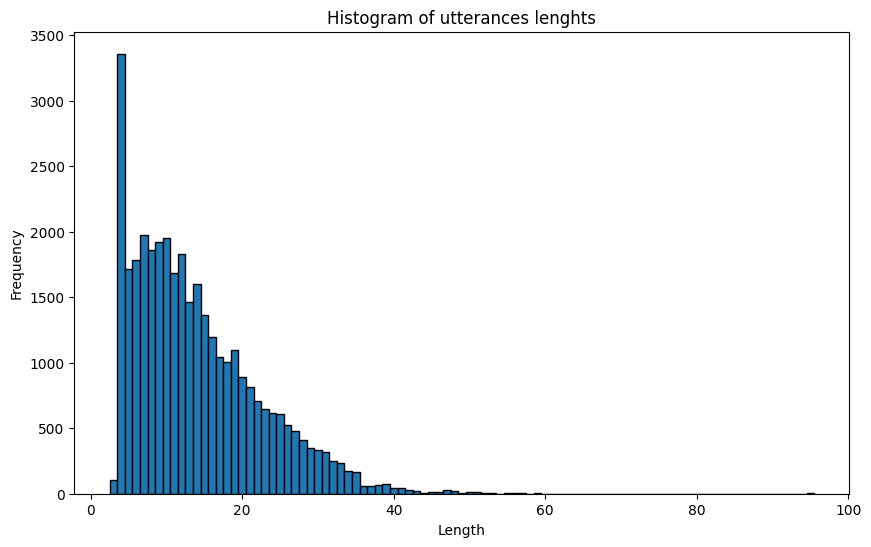

Percentile values:
0.25 : 7.0
0.5 : 12.0
0.75 : 19.0
0.9 : 26.0
0.95 : 30.0
1.0 : 95.0


In [ ]:
create_utterances_histogram(df['utterances_tokenized'].explode(),"Histogram of utterances lenghts")

### Emotions Column

Again, we check for `None`/`Nan` values:

In [ ]:
df['emotions'].explode().isna().any()

False

And we take a look at class distribution:

In [ ]:
def create_histogram(df, column, title):
  '''
  Create df histogram
  '''

  plt.figure(figsize=(10,6))
  df.plot(kind='bar', color='skyblue')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.title(f'{column} Counts')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
emotions = df['emotions'].explode()
emotions_classes = list(emotions.unique())

In [ ]:
emotions.value_counts()

,count
emotions,
neutral,15263
joy,6317
surprise,4645
anger,3964
sadness,2648
fear,1114
disgust,1049


The table shows an obvious imbalance of the emotions. In fact, the `neutral` class is present almost three times as much as the second most frequent class, which is `joy`.
In the following histogram, this imbalance is visible.








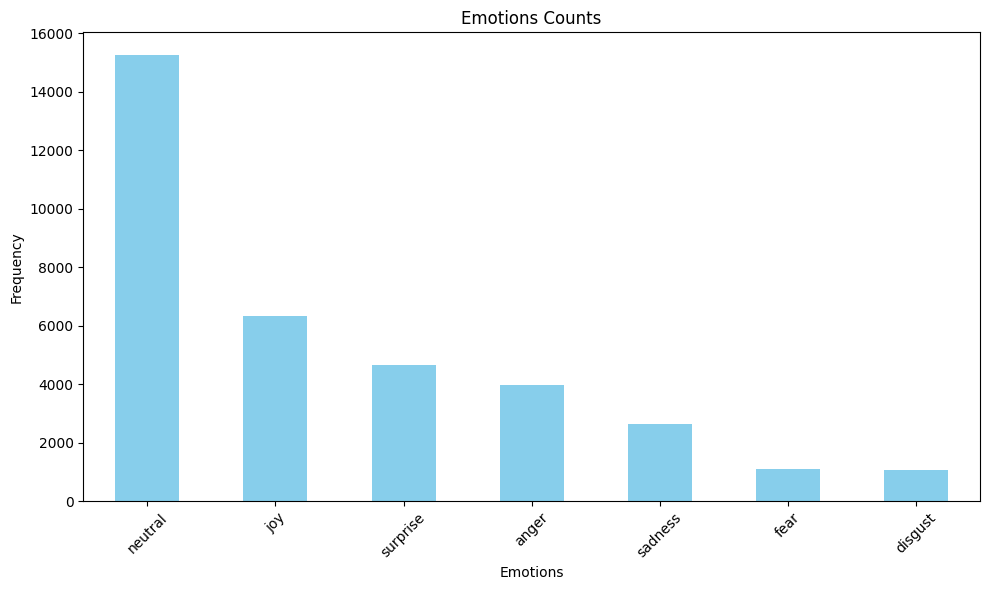

In [ ]:
create_histogram(emotions.value_counts(), 'Emotions', "Emotions Counts")

### Triggers Column

Finally, we analyze the `triggers` column.
We check for `None`/`Nan` values and we find some.

In [ ]:
df['triggers'].explode().isna().any()

True

Values in triggers column:

In [ ]:
df['triggers'].explode().unique()

array([0.0, 1.0, None], dtype=object)

Thus, we convert any `Nan`/`None` value to 0.

In [ ]:
none_in_triggers = df[df['triggers'].apply(lambda x: any(t is None or pd.isna(t) for t in x))].index.tolist()
print(f"None or Nan value in dataset before: {len(none_in_triggers)}")

for idx in none_in_triggers:
  row = df.at[idx, 'triggers']
  # Replace 'None' and 'nan' values with 0
  df.at[idx, 'triggers'] = [0 if e is None or pd.isna(e) else e for e in row]

none_in_triggers = df[df['triggers'].apply(lambda x: any(t is None or pd.isna(t) for t in x))].index.tolist()
print(f"None or Nan value in dataset after: {len(none_in_triggers)}")


None or Nan value in dataset before: 9
None or Nan value in dataset after: 0


In [ ]:
triggers_classes = df['triggers'].explode().unique()
triggers_classes

array([0.0, 1.0], dtype=object)

And we plot a histogram of the triggers.

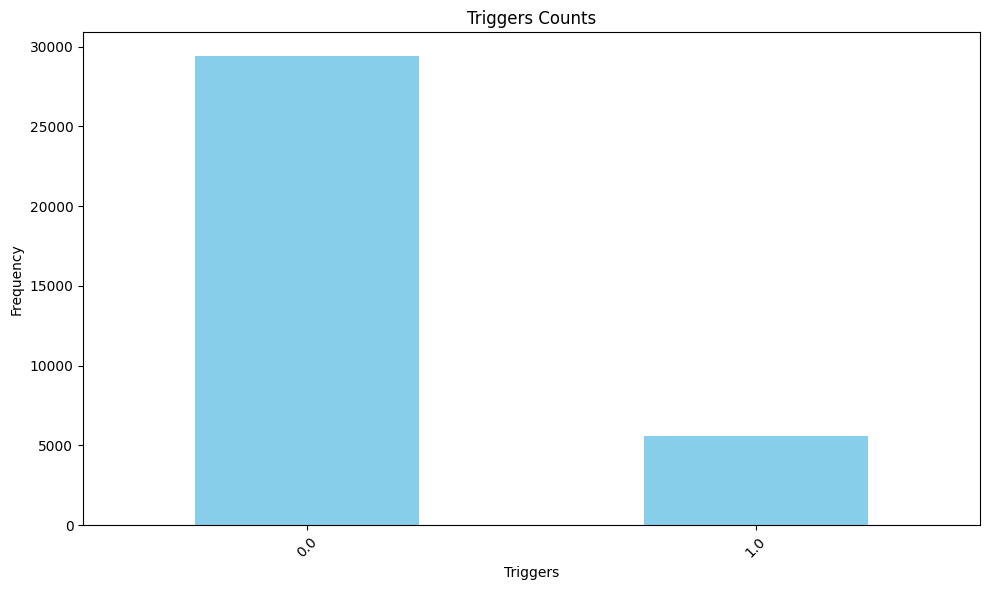

In [ ]:
create_histogram(df['triggers'].explode().value_counts(), 'Triggers', "Triggers Counts")

Highlighting a deep unbalance between the positive trigger (1.0, where there is an actual `emotion` flip) and the negative trigger (0.0, where no `emotion` flips happen).

### Train, Validation, Test split

We finally move forward and execute an 80/10/10 train/val/test split, as recommended by the project guidelines:

In [ ]:
df_train, dff = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(dff, test_size=0.5, random_state=42)

And we show the first few examples of each of the three sets.

In [ ]:
df_train = df_train.reset_index()
df_train = df_train.drop(columns=['index'])
df_train.head()

,episode,speakers,emotions,utterances,triggers,utterances_tokenized
0,utterance_3994,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[[101, 4931, 1012, 102], [101, 4931, 999, 102]..."
1,utterance_423,"[Monica, Monica]","[surprise, fear]","[And y'know what, I just realised, in the last...","[1.0, 1.0]","[[101, 1998, 1061, 1005, 2113, 2054, 1010, 104..."
2,utterance_2991,"[Rachel, Mr. Treeger, Rachel]","[fear, neutral, joy]","[Oh! Hey, Mr. Treeger., : What are you doing?,...","[1.0, 0.0, 1.0]","[[101, 2821, 999, 4931, 1010, 2720, 1012, 3392..."
3,utterance_1221,"[Chandler, Monica, Chandler, Monica, Chandler,...","[neutral, neutral, neutral, surprise, sadness,...","[Okay to come in?, Yeah, come on, eat, whateve...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[101, 3100, 2000, 2272, 1999, 1029, 102], [10..."
4,utterance_506,"[Ross, Chandler, Ross, Chandler]","[neutral, neutral, neutral, joy]","[Ok, bye. Well, Monica's not coming, it's jus...","[1.0, 0.0, 0.0, 0.0]","[[101, 7929, 1010, 9061, 1012, 2092, 1010, 901..."


In [ ]:
df_val = df_val.reset_index()
df_val = df_val.drop(columns=['index'])
df_val.head()

,episode,speakers,emotions,utterances,triggers,utterances_tokenized
0,utterance_1987,"[Phoebe, Phoebe Sr, Phoebe, Phoebe Sr, Phoebe,...","[sadness, surprise, neutral, surprise, neutral...","[I'm sorry., What are you doing here?!, I-I, c...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[[101, 1045, 1005, 1049, 3374, 1012, 102], [10..."
1,utterance_2893,"[Rachel, Rachel, Rachel, Rachel, Stranger, Rac...","[sadness, sadness, fear, neutral, neutral, joy]","[Mom, would you relax., That was 10 blocks fro...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[[101, 3566, 1010, 2052, 2017, 9483, 1012, 102..."
2,utterance_1860,"[Monica, Chandler, Monica, Chandler, Monica]","[surprise, joy, surprise, joy, joy]","[What did you just say?, You roll another hard...","[0.0, 0.0, 0.0, 1.0, 0.0]","[[101, 2054, 2106, 2017, 2074, 2360, 1029, 102..."
3,utterance_3829,"[Monica, Chandler, Monica, Chandler, The Museu...","[neutral, neutral, joy, anger, neutral, surpri...","[Hi, honey., See you later., What? I-I bought ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[[101, 7632, 1010, 6861, 1012, 102], [101, 215..."
4,utterance_240,"[Chandler, Bob, Chandler, Bob, Chandler, Mr. F...","[neutral, joy, neutral, joy, joy, neutral, neu...","[Hey Bob., Hey! How's my pal Toby doing today?...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[[101, 4931, 3960, 1012, 102], [101, 4931, 999..."


In [ ]:
df_test = df_test.reset_index()
df_test = df_test.drop(columns=['index'])
df_test.head()

,episode,speakers,emotions,utterances,triggers,utterances_tokenized
0,utterance_2335,"[Janice, Rachel, Janice, Rachel, Janice, Rache...","[neutral, neutral, neutral, neutral, neutral, ...","[He's a keeper. How are you feeling?, Oh, I'm ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[[101, 2002, 1005, 1055, 1037, 10684, 1012, 21..."
1,utterance_3722,"[Ross, Cassie, Ross]","[neutral, neutral, joy]","[Cassie, how you-how you doin' on that hot dog...","[0.0, 1.0, 0.0]","[[101, 8869, 1010, 2129, 2017, 1011, 2129, 201..."
2,utterance_3379,"[Joey, Chandler, Joey, Chandler, Chandler, Cha...","[neutral, neutral, neutral, neutral, neutral, ...","[Sure, I can hang out til I have to meet ya. ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[101, 2469, 1010, 1045, 2064, 6865, 2041, 186..."
3,utterance_2313,"[Kim, Nancy, Rachel, Kim, Rachel, Nancy, Kim, ...","[neutral, joy, joy, neutral, neutral, neutral,...","[So, we're decided, no on plaid, yes on pink?,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[101, 2061, 1010, 2057, 1005, 2128, 2787, 101..."
4,utterance_3782,"[Phoebe, Phoebe, Rachel, Phoebe, Phoebe, Phoebe]","[surprise, surprise, joy, surprise, joy, neutral]",[You mean whenever Monica and Chandler where l...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[[101, 2017, 2812, 7188, 9018, 1998, 13814, 20..."


### Encoding the model input

Since we are going to work with a pretrained BERT model, with maximum token length of 512, we need to decide the lengths of dialogues and utterances, and their relative padding/truncation, to go as input to the model.
From our previous analysis, we obtained the percentiles of both dialogues and utterances lengths.

```
Percentile Values for dialogue lengths:
0.25 : 5.0
0.5 : 8.0
0.75 : 12.0
0.9 : 16.0
0.95 : 18.0
1.0 : 24.0

```

```
Percentile Values for utterance lengths:
0.25 : 7.0
0.5 : 12.0
0.75 : 19.0
0.9 : 26.0
0.95 : 30.0
1.0 : 95.0
```


Also based on these stats, we decided to consider 16 (90th percentile) as the dialogues length and 32 (~95th percentile) as the utterances length, padding or truncating depending on the length of each sequence.
The choice was made in order to fill the whole input of BERT and, thus, to deploy all its resources for an exaustive experiment. In fact: 16 * 32 = 512.

In [ ]:
MAX_DLG_LEN = 16
MAX_UTT_LEN = 32

Now, we move to the input encoding.
It will be represented by two numpy arrays of size (#EXAMPLES, `MAX_DLG_LEN`, `MAX_UTT_LEN`), one for tokenized dialogues and one for tokenized attention masks, both padded or truncated in order to reach the dimensions we just selected.

In [ ]:
def encode_input(X) -> np.array:
  '''
  Tokenize, add padding or truncate sequences of a pandas DataFrame column of dialogues
  where each dialogue is a list of utterances.

  Parameters:
    - X: Pandas DataFrame column of dialogues

  Returns:
    - token_ids numpy array
    - attention_mask numpy array
  '''
  tokenized_dialogues = []
  attention_dialogues = []
  pad_id = tokenizer.pad_token_id

  for dialogue in X:
    tokenized_utterances = []
    attention_utterances = []

    for utterance in dialogue:
      # Tokenize the utterance
      utt_tokenized = tokenizer(utterance, padding='max_length', truncation=True, max_length=MAX_UTT_LEN)
      tokenized_utterances.append(utt_tokenized['input_ids'])
      attention_utterances.append(utt_tokenized['attention_mask'])

    # Truncate or pad the number of utterances in the dialogue
    if len(tokenized_utterances) > MAX_DLG_LEN:
      tokenized_utterances = tokenized_utterances[:MAX_DLG_LEN]
      attention_utterances = attention_utterances[:MAX_DLG_LEN]
    else:
      # Pad with arrays of zeros to reach the desired number of utterances
      tokenized_utterances += [[pad_id] * MAX_UTT_LEN] * (MAX_DLG_LEN - len(tokenized_utterances))
      attention_utterances += [[pad_id] * MAX_UTT_LEN] * (MAX_DLG_LEN - len(attention_utterances))

    tokenized_dialogues.append(np.array(tokenized_utterances))
    attention_dialogues.append(np.array(attention_utterances))

  return np.array(tokenized_dialogues), np.array(attention_dialogues)


In [ ]:
X_train_input_ids, X_train_attention_mask = encode_input(df_train['utterances'])
X_val_input_ids, X_val_attention_mask = encode_input(df_val['utterances'])
X_test_input_ids, X_test_attention_mask = encode_input(df_test['utterances'])

### Encoding the model outputs

The encoding of the output will cover both the `emotions` and the `triggers`, via one-hot encodings.

Let's go with the `emotions` first.

Since we want to one-hot encode this column, we need to create a dictionary first, adding the `PAD` token as the class for utterances only made of padding.

In [ ]:
emotions_dict = {category: index for index, category in enumerate(emotions_classes)}
EMOTIONS_PAD = 7
emotions_dict["PAD"] = EMOTIONS_PAD
emotions_dict

{'neutral': 0,
 'surprise': 1,
 'fear': 2,
 'sadness': 3,
 'joy': 4,
 'disgust': 5,
 'anger': 6,
 'PAD': 7}

In [ ]:
EMOTIONS_LEN = len(emotions_dict)

Now, we can one-hot encode `emotions`, obtaining a numpy array of size (#EXAMPLES, `MAX_UTT_LEN`, `EMOTION_LEN`).

In [ ]:
def encode_output_emotions(Y, emotion_dict):
    """
    Encode emotions using one-hot encoding, along with padding/truncate

    Parameters:
    - Y: Series of emotions.
    - emotion_dict: Dictionary mapping emotion names to indices.

    Returns:
    - Numpy array of emotions indices, padded or truncated to MAX_DLG_LEN.
    """

    # Map each emotion in Y to its corresponding index
    Y_indexed = Y.apply(lambda y: [emotion_dict[e] for e in y])
    pad_index = emotion_dict.get('PAD')

    # Convert each index to a one-hot encoded vector
    Y_onehot = Y_indexed.apply(lambda y: [to_categorical(e, EMOTIONS_LEN) for e in y])

    # Pad or truncate each list of one-hot encoded emotions to MAX_DLG_LEN
    Y_padded = Y_onehot.apply(
        lambda y: y[:MAX_DLG_LEN] + [to_categorical(pad_index, EMOTIONS_LEN)] * (MAX_DLG_LEN - len(y))
        if len(y) < MAX_DLG_LEN else y[:MAX_DLG_LEN]
    )

    # Convert the padded/truncated one-hot encoded emotions to a numpy array
    Y = np.array(Y_padded.tolist())

    return Y


In [ ]:
Y_train_emotions = encode_output_emotions(df_train['emotions'], emotions_dict)
Y_val_emotions = encode_output_emotions(df_val['emotions'], emotions_dict)
Y_test_emotions = encode_output_emotions(df_test['emotions'], emotions_dict)

Now the `triggers`.

Since `triggers` values are already numbers, there's no need to create a dictionary as for emotions, we just need to add the `triggers` value '2' to represent utterances only made of padding. We can, now, go ahead and perform the one-hot encoding.

In [ ]:
TRIGGERS_LEN = 3
TRIGGERS_PAD = 2

In [ ]:
def encode_output_triggers(Y):
    """
    Encode triggers using one-hot encoding, along with padding/truncate

    Parameters:
    - Y: Series of triggers.

    Returns:
    - Numpy array of trigger indices, padded or truncated to MAX_DLG_LEN.
    """
    pad_index = TRIGGERS_PAD

    # Convert each triggers to a one-hot encoded vector
    Y_onehot = Y.apply(lambda y: [to_categorical(e, TRIGGERS_LEN) for e in y])

    # Pad or truncate each list of one-hot encoded trigggers to MAX_DLG_LEN
    Y_padded = Y_onehot.apply(
        lambda y: y[:MAX_DLG_LEN] + [to_categorical(pad_index, TRIGGERS_LEN)] * (MAX_DLG_LEN - len(y))
        if len(y) < MAX_DLG_LEN else y[:MAX_DLG_LEN]
    )

    # Convert the padded/truncated one-hot encoded triggers to a numpy array
    Y = np.array(Y_padded.tolist())

    return Y


In [ ]:
Y_train_triggers = encode_output_triggers(df_train['triggers'])
Y_val_triggers = encode_output_triggers(df_val['triggers'])
Y_test_triggers = encode_output_triggers(df_test['triggers'])

# Metrics

The requested metrics for the evaluation are:


*   `Sequence F1`: compute the f1-score for each dialogue and report the average score.
*   `Unrolled Sequence F1`: flatten all utterances and compute the f1-score.



In [ ]:
def sequence_f1(Y_true: np.ndarray, Y_pred: np.ndarray, pad_index: int, average_type: str ='macro') -> float:
    '''
    Calculates the f1-score for each dialogue excluding padding and returns the averaged score on all dialogues.

    Parameters:
      Y_true : array of true labels, each label is a 2D array of one-hot encoded labels.
      Y_pred : array of predicted labels with the same structure as Y_true.
      pad_index : int, the index used for padding in one-hot encoded arrays.
      average_type : The method to calculate the F1-score (e.g., 'macro', 'micro', 'weighted')

    Returns:
      The average of F1-scores of all the dialogue, excluding padding.
    '''
    f1_scores = []
    for i in range(len(Y_true)):
        labels_true = np.argmax(Y_true[i], axis=-1)
        labels_pred = np.argmax(Y_pred[i], axis=-1)

        # Exclude padding from the evaluation
        valid_indices = labels_true != pad_index
        labels_true = labels_true[valid_indices]
        labels_pred = labels_pred[valid_indices]

        f1 = f1_score(labels_true, labels_pred, average=average_type)
        f1_scores.append(f1)
    return np.mean(f1_scores)


In [ ]:
def unrolled_f1(Y_true: np.ndarray, Y_pred: np.ndarray, pad_index: int, average_type: str = 'macro') -> float:
    '''
    Calculates the F1-score by unrolling all dialogues into a single array and computing the score across all utterances, excluding padding.

    Parameters:
      Y_true : array of true labels, each label is a 2D array of one-hot encoded labels.
      Y_pred : array of predicted labels with the same structure as Y_true.
      pad_index : int, the index used for padding in one-hot encoded arrays.
      average_type : The method to calculate the F1-score

    Returns:
      A single F1-score computed over the entire unrolled set of dialogues, excluding padding.
    '''
    if Y_true.ndim == 3:  # Check for a three-dimensional array typical of batched one-hot encoded labels
        Y_true = np.argmax(Y_true, axis=-1).flatten()
        Y_pred = np.argmax(Y_pred, axis=-1).flatten()
    else:
        raise ValueError("Expected a three-dimensional array for one-hot encoded labels.")

    # Exclude padding from the evaluation
    valid_indices = Y_true != pad_index
    Y_true = Y_true[valid_indices]
    Y_pred = Y_pred[valid_indices]

    return f1_score(Y_true, Y_pred, average=average_type)


# Models

In this section we build the models, the baselines and the BERT-based ones.



## Baseline Models

We start with the two baseline models:


*   `Random Uniform Classifier`, generating predictions uniformly at random.
*   `Majority Classifier`, always returning the most frequent class label.

In [ ]:
def baseline_model(X_train, Y_train, X_test, strategy: str, num_classes, pad_index, random_state=None):
    """
    Evaluate a baseline model using the DummyClassifier with a specified strategy.
    Returns predictions one-hot encoded to match the original structure of Y_train,
    adapted for multi-class classification, excluding padding indexes during training.

    Parameters:
    - X_train: Input training dataset, shape (num_dialogues, MAX_DLG_LEN, MAX_UTT_LEN).
    - Y_train: Labels for the training dataset, shape (num_dialogues, MAX_DLG_LEN, num_classes).
    - X_test: Input testing dataset, shape like X_train.
    - strategy (str): Strategy to use for the DummyClassifier.
    - num_classes (int): Number of classes for one-hot encoding.
    - pad_index (int): Index used for padding in Y_train to be excluded.
    - random_state (int, optional): Random state for reproducibility.

    Returns:
    - numpy array of model predictions one-hot encoded to match Y_train's shape.
    """
    num_dialogues = X_test.shape[0]

    # Flatten the input to treat each utterance as a separate sample
    X_train_flat = X_train.reshape(-1, MAX_UTT_LEN)
    X_test_flat = X_test.reshape(-1, MAX_UTT_LEN)

    # Convert one-hot encoded Y_train to class indices, then flatten
    Y_train_indices = np.argmax(Y_train, axis=-1).flatten()

    # Exclude padding from training data
    valid_indices = Y_train_indices != pad_index
    X_train_flat_valid = X_train_flat[valid_indices]
    Y_train_flat_valid = Y_train_indices[valid_indices]

    # Initialize the DummyClassifier
    classifier = DummyClassifier(strategy=strategy, random_state=random_state)
    classifier.fit(X_train_flat_valid, Y_train_flat_valid)

    # Predict on the flattened test data
    pred_flat = classifier.predict(X_test_flat)

    # Ensure the number of predictions matches the number of test samples
    if len(pred_flat) != X_test_flat.shape[0]:
        raise ValueError(f"Number of predictions {len(pred_flat)} does not match the number of test samples {X_test_flat.shape[0]}")

    # One-hot encode predictions
    pred_one_hot = to_categorical(pred_flat, num_classes)

    # Reshape predictions to match the shape of Y_train (dialogue, utterance, num_classes)
    pred = pred_one_hot.reshape(num_dialogues, MAX_DLG_LEN, num_classes)

    return pred

In [ ]:
#Emotions
Y_pred_emotions_most_frequent = baseline_model(X_train_input_ids, Y_train_emotions, X_val_input_ids, "most_frequent", EMOTIONS_LEN, 7)
Y_pred_emotions_uniform = baseline_model(X_train_input_ids, Y_train_emotions, X_val_input_ids, "uniform", EMOTIONS_LEN, 7)

#Triggers
Y_pred_triggers_most_frequent = baseline_model(X_train_input_ids, Y_train_triggers, X_val_input_ids, "most_frequent", TRIGGERS_LEN, 2)
Y_pred_triggers_uniform = baseline_model(X_train_input_ids, Y_train_triggers, X_val_input_ids, "uniform", TRIGGERS_LEN, 2)

## BERT Models

The BERT-based models are built deploying the `bert-base-uncased ` variation.

We also trained and evaluated the models with the BERT moden `Frozen` and `Unfrozen`, respectively, freezing the BERT embedding layer weights and fine-tuning the classifier heads on top, and fine-tuning the whole model architecture.

But first, we need to determine the hyperparameters for the best training.

#### Hyperparameters tuning
For an initial baseline where to start from, we deployed the `KerasTuner`, and we looked for:


*   the number of activations for each of the layers of the heads,
*   the number of layers of each head,
*   the learning rate.

We do this only for the model with `Frozen` BERT, and we use the values found also for the `Unfrozen` BERT, for  coherence.



In [ ]:
def build_model(hp):
  model_card = 'bert-base-uncased'
  bert_model = TFBertModel.from_pretrained(model_card)

  # Freeze the BERT layers
  for layer in bert_model.layers:
      layer.trainable = False

  #Input
  input_ids = keras.layers.Input(shape=(None,None,), dtype=tf.int32, name='input_ids')
  attention_mask = keras.layers.Input(shape=(None,None,), dtype=tf.int32, name='attention_mask')
  input_ids_flatten = Flatten()(input_ids)
  attention_mask_flatten = Flatten()(attention_mask)

  #BERT
  bert_output = bert_model(input_ids=input_ids_flatten,attention_mask=attention_mask_flatten)["last_hidden_state"]
  #Output is (batch_size,dialogue_tokens,768) so it's token contexual encoding
  max_pooling_layer = MaxPooling1D(pool_size=MAX_UTT_LEN)(bert_output)
  #Output is (batch_size,MAX_DLG_LEN,768) so it's sentence by sentence encoding (equal to BERT pooler output)

  #CLF Head Triggers
  head1 = Dense(hp.Int("Head1 layer1 activations", min_value=5,max_value=70,step=5), activation='relu')(max_pooling_layer)
  head1 = Dropout(0.5)(head1)
  for i in range(hp.Choice("Head1 num layers",[0, 1])):
    head1 = Dense(hp.Int(f"Head1 layer{i+2} activations", min_value=30,max_value=130,step=10), activation='relu')(head1)
    head1 = Dropout(0.5)(head1)
  output1 = Dense(TRIGGERS_LEN , activation='softmax', name='output1')(head1)

  #CLF Head Emotions
  head2 = Dense(hp.Int("Head2 layer1 activations",min_value=80,max_value=110,step=10), activation='relu')(max_pooling_layer)
  head2 = Dropout(0.5)(head2)
  for i in range(hp.Choice("Head2 num layers",[0, 1])):
    head2 = Dense(hp.Int(f"Head2 layer{i+2} activations", min_value=30,max_value=70,step=10), activation='relu')(head2)
    head2 = Dropout(0.5)(head2)
  output2 = Dense(EMOTIONS_LEN, activation='softmax', name='output2')(head2)

  model = Model(inputs=[input_ids,attention_mask], outputs=[output1,output2])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("Learning Rate",[1e-3, 1e-4])), loss=['categorical_crossentropy','categorical_crossentropy'], metrics=['accuracy'])
  return model


The `input_ids` and the `attention_mask` have been flattened, in order to be compatible with BERT’s input requirements.

In [ ]:
tuner = kt.RandomSearch(build_model,objective='val_loss',max_trials=5)

As follows, the results of the five trials conducted.

In [ ]:
tuner.search(x=[X_train_input_ids,X_train_attention_mask], y=[Y_train_triggers,Y_train_emotions], epochs=5, validation_data = ([X_val_input_ids,X_val_attention_mask],[Y_val_triggers,Y_val_emotions]))

Trial 5 Complete [00h 07m 17s]
val_loss: 1.018389105796814

Best val_loss So Far: 0.9247248768806458
Total elapsed time: 00h 36m 14s


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
Head1 layer1 activations: 55
Head1 num layers: 0
Head2 layer1 activations: 110
Head2 num layers: 0
Learning Rate: 0.001
Head1 layer2 activations: 90
Score: 0.9247248768806458

Trial 0 summary
Hyperparameters:
Head1 layer1 activations: 10
Head1 num layers: 1
Head2 layer1 activations: 100
Head2 num layers: 0
Learning Rate: 0.001
Head1 layer2 activations: 30
Score: 0.969024658203125

Trial 4 summary
Hyperparameters:
Head1 layer1 activations: 70
Head1 num layers: 0
Head2 layer1 activations: 90
Head2 num layers: 1
Learning Rate: 0.001
Head1 layer2 activations: 100
Head2 layer2 activations: 30
Score: 1.018389105796814

Trial 3 summary
Hyperparameters:
Head1 layer1 activations: 50
Head1 num layers: 1
Head2 layer1 activations: 100
Head2 num layers: 0
Learning Rate: 0.0001
Head1 layer2 activations: 130
Score: 1.061495065689087

Trial 2 summary
Hyperp

As shown in the results, the **best hyperparameters** are:
*   Head1 layer1 activations: 55
*   Head1 num layers: 0
*   Head2 layer1 activations: 110
*   Head2 num layers: 0
*   Learning Rate: 0.001

### Model building


Starting from the values obtained using the KerasTuner, we conducted some tests with several different configurations and we chose the following one.

In [ ]:
def build_BERT_model(unfrozen : bool):
  model_card = 'bert-base-uncased'
  bert_model = TFAutoModel.from_pretrained(model_card)

  # Freeze the BERT layers
  for layer in bert_model.layers:
      layer.trainable = unfrozen

  #Input
  input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
  attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
  input_ids_flatten = Flatten(name='input_ids_flattened')(input_ids)
  attention_mask_flatten = Flatten(name='attention_mask_flatten')(attention_mask)

  #BERT
  bert_output = bert_model(input_ids=input_ids_flatten,attention_mask=attention_mask_flatten)["last_hidden_state"]
  #Output is (batch_size,MAX_DLG_LEN*MAX_UTT_LEN,768) so it's token contexual encoding
  max_pooling_layer = MaxPooling1D(pool_size=MAX_UTT_LEN)(bert_output)
  #Output is (batch_size,MAX_DLG_LEN,768) so it's sentence by sentence encoding

  #CLF Head Triggers
  head1 = Dense(256, activation='relu')(max_pooling_layer)
  head1 = Dropout(0.1)(head1)
  head1 = Dense(128, activation='relu')(head1)
  head1 = Dropout(0.1)(head1)
  output1 = Dense(TRIGGERS_LEN , activation='softmax', name='triggers_head')(head1)

  #CLF Head Emotions
  head2 = Dense(256, activation='relu')(max_pooling_layer)
  head2 = Dropout(0.1)(head2)
  head2 = Dense(128, activation='relu')(head2)
  head2 = Dropout(0.1)(head2)
  output2 = Dense(EMOTIONS_LEN, activation='softmax', name='emotions_head')(head2)

  model = Model(inputs=[input_ids,attention_mask], outputs=[output1,output2])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=[keras.losses.categorical_crossentropy,keras.losses.categorical_crossentropy], metrics=['accuracy'])

  return model

In [ ]:
model = build_BERT_model(True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_ids_flattened (Flatt  (None, None)                 0         ['input_ids[0][0]']           
 en)                                                                                              
                                                                                              

Here's a visualization of our model.

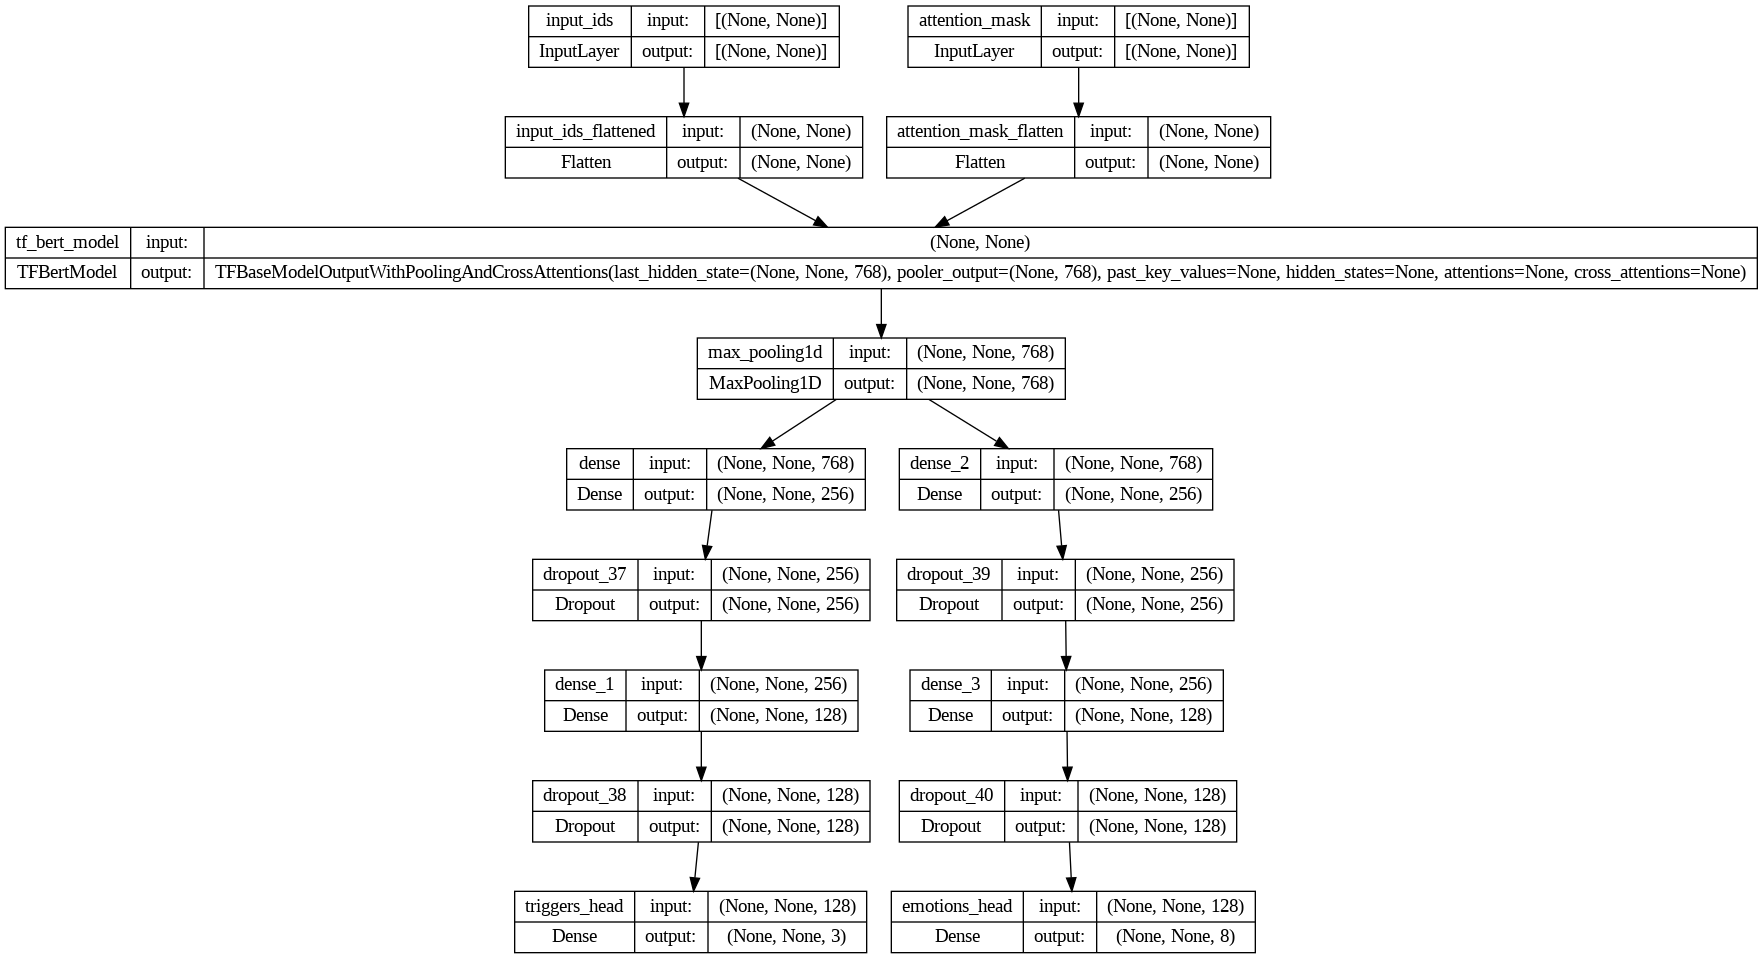

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Training and evaluation

In order to manage results, we created a class named `Results`, saving results for each model, strategy and class.
We also compute mean and standard deviation across **5 seeds** and print the results for comparison.

In [ ]:
class Results():
  """
  A class for managing, computing, and storing results, predictions, and statistical metrics.

  Attributes:
      results (dict): Stores the F1 scores for different models, classes, and strategies.
      y_pred (dict): Stores the predicted outputs for different models, classes, and strategies.
      mean (dict): Stores the mean F1 scores for the results.
      st_dev (dict): Stores the standard deviation of the F1 scores.
  """
  def __init__(self):
      """
      Initializes an empty Results object with dictionaries for results, predictions,
      mean scores, and standard deviations.
      """

      self.results = {}
      self.y_pred = {}
      self.mean = {}
      self.st_dev = {}

  def compute_score(self,Y,Y_pred,class_name):
      """
      Computes sequence and unrolled F1 scores for the given predictions and ground truths.

      Args:
          Y (array-like): Ground truth labels.
          Y_pred (array-like): Predicted labels.
          class_name (str): Class name, either "emotions" or "triggers".

      Returns:
          list: A list containing sequence F1 score and unrolled F1 score.
      """

      if class_name == "emotions":
        padding_token = EMOTIONS_PAD
      elif class_name == "triggers":
        padding_token = TRIGGERS_PAD
      sequence_f1_score = sequence_f1(Y, Y_pred, pad_index=padding_token)
      unrolled_f1_score = unrolled_f1(Y, Y_pred, pad_index=padding_token)
      return [sequence_f1_score,unrolled_f1_score]

  def save_scores(self,name,scores):
      """
      Saves the sequence and unrolled F1 scores for a given model, class, and strategy.

      Args:
          name (str): Unique identifier for the model, class, and strategy.
          scores (list): F1 scores [sequence_f1_score, unrolled_f1_score].
      """

      if name not in self.results:
        self.results[name] = [[],[]]
      self.results[name][0].append(scores[0])
      self.results[name][1].append(scores[1])

  def print_scores(self,name):
      """
      Prints the most recent sequence and unrolled F1 scores for a given identifier.

      Args:
          name (str): Unique identifier for the model, class, and strategy.
      """

      print(f"Sequence F1 score for {name}: {self.results[name][0][-1]}")
      print(f"Unrolled F1 score for {name}: {self.results[name][1][-1]}")

  def save_y_pred(self,name,Y_pred):
      """
      Saves the predicted outputs for a given model, class, and strategy.

      Args:
          name (str): Unique identifier for the model, class, and strategy.
          Y_pred (array-like): Predicted labels.
      """

      if name not in self.y_pred:
        self.y_pred[name] = []
      self.y_pred[name].append(Y_pred.tolist())

  def set_results(self, Y, Y_pred, model, class_name, strategy):
      """
      Computes and saves scores, predictions, and prints results for a specific model and strategy.

      Args:
          Y (array-like): Ground truth labels.
          Y_pred (array-like): Predicted labels.
          model (str): Model name.
          class_name (str): Class name ("emotions" or "triggers").
          strategy (str): Strategy identifier.
      """

      name = f"{model}_{class_name}_{strategy}"
      scores = self.compute_score(Y, Y_pred, class_name)
      self.save_scores(name,scores)
      self.save_y_pred(name,Y_pred)
      self.print_scores(name)

  def dump(self):
      """
      Dumps all stored results, predictions, means, and standard deviations into JSON files.
      """

      with open('results.json', 'w') as f:
        json.dump(self.results, f)
      with open('y_pred.json', 'w') as f:
        json.dump(self.y_pred, f)
      with open('mean.json', 'w') as f:
        json.dump(self.mean, f)
      with open('st_dev.json', 'w') as f:
        json.dump(self.st_dev, f)

  def compute_mean_st_dev(self):
      """
      Computes the mean and standard deviation for all stored results.
      """

      for key,value in self.results.items():
        self.mean[key] = np.mean(value,axis=1)
        self.st_dev[key] = np.std(value,axis=1)

  def print_results(self):
      """
      Displays a summary of mean F1 scores and their standard deviations in a tabular format.
      """

      results_df = pd.DataFrame.from_dict(results.mean, orient='index', columns=['Sequence F1', 'Unrolled F1'])
      results_df['StDev Sequence F1'] = [results.st_dev[key][0] for key in results.st_dev]
      results_df['StDev Unrolled F1'] = [results.st_dev[key][1] for key in results.st_dev]
      display(results_df)

We define a function to visualize the behavior of the `loss` and `val_loss` functions, in order to check for possible over- or under-fitting.

In [ ]:
def plot_training_history(history,model_name):
    """
    Plots the training and validation loss and accuracy for a model's history.

    Parameters:
        history (keras.callbacks.History): The history object returned by model.fit.
    """

    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.subplot(3,1,1)
    plt.plot(epochs, history_dict['loss'], label='Training Loss', marker='o')
    plt.plot(epochs, history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(3, 1, 2)
    plt.plot(epochs, history_dict['triggers_head_loss'], label='Triggers Loss', marker='o')
    plt.plot(epochs, history_dict['val_triggers_head_loss'], label='Triggers Validation Loss', marker='o')
    plt.title(f'Training and Validation Loss for Triggers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()



    plt.subplot(3, 1, 3)
    plt.plot(epochs, history_dict['emotions_head_loss'], label='Emotions Loss', marker='o')
    plt.plot(epochs, history_dict['val_emotions_head_loss'], label='Emotions Validation Loss', marker='o')
    plt.title(f'Training and Validation Loss for Emotions')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

And we also added a model checkpoint to save the best weights, following the behavior of the `val_loss`.

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='best_weights.h5',  # Filepath to save the weights
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    save_best_only=True,        # Save only the best weights
    mode='min'                  # 'min' for loss, 'max' for accuracy
)

### Training

For a robust assessment and a sound evaluation of the model, we trained both the baselines and the BERT-based models across 5 seeds and we collected the results obtained.

The training of all the models (baselines and BERT-based ones) can now start.

In [ ]:
results = Results()

classes = ["emotions", "triggers"]
strategy = ["most_frequent", "uniform"]

In [ ]:
def seed_training(seed):
  print(f"Seed: {seed}")

  #Setting numpy and tf random seed for reproducibility
  np.random.seed(seed)
  tf.random.set_seed(seed)

  #Baseline models
  for class_name in classes:
    for strat in strategy:
      print(f"Baseline: Class: {class_name}, Strategy: {strat}")
      if class_name == "emotions":
        Y_pred = baseline_model(X_train_input_ids, Y_train_emotions, X_val_input_ids, strat, EMOTIONS_LEN, EMOTIONS_PAD, seed)
        results.set_results(Y_test_emotions, Y_pred, "Baseline", class_name, strat)
      elif class_name == "triggers":
        Y_pred = baseline_model(X_train_input_ids, Y_train_triggers, X_val_input_ids, strat, TRIGGERS_LEN, TRIGGERS_PAD, seed)
        results.set_results(Y_test_triggers, Y_pred, "Baseline", class_name, strat)

  #BERT models
  #Frozen
  print("Frozen BERT")
  frozen_BERT_model = build_BERT_model(unfrozen=False)
  frozen_history = frozen_BERT_model.fit(batch_size=32, x = [X_train_input_ids,X_train_attention_mask], validation_data = ([X_val_input_ids,X_val_attention_mask],[Y_val_triggers,Y_val_emotions]), y =[Y_train_triggers,Y_train_emotions], epochs=10, callbacks=[checkpoint]);
  plot_training_history(frozen_history,"Frozen BERT")
  frozen_BERT_model.load_weights('best_weights.h5')
  Y_pred = frozen_BERT_model.predict([X_test_input_ids,X_test_attention_mask])
  results.set_results(Y_test_triggers, Y_pred[0], "BERT", "triggers", "frozen")
  results.set_results(Y_test_emotions, Y_pred[1], "BERT", "emotions", "frozen")

  #Clear memory
  del frozen_BERT_model
  K.clear_session()
  gc.collect()

  #Unfrozen
  print("Unfrozen BERT")
  unfrozen_BERT_model = build_BERT_model(unfrozen=True)
  unfrozen_history = unfrozen_BERT_model.fit(batch_size=8, x = [X_train_input_ids,X_train_attention_mask], validation_data = ([X_val_input_ids,X_val_attention_mask],[Y_val_triggers,Y_val_emotions]), y =[Y_train_triggers,Y_train_emotions], epochs=10, callbacks=[checkpoint]);
  plot_training_history(unfrozen_history,"Unfrozen BERT")
  unfrozen_BERT_model.load_weights('best_weights.h5')
  Y_pred = unfrozen_BERT_model.predict([X_test_input_ids,X_test_attention_mask])
  results.set_results(Y_test_triggers, Y_pred[0], "BERT", "triggers", "unfrozen")
  results.set_results(Y_test_emotions, Y_pred[1], "BERT", "emotions", "unfrozen")

  #Clear memory
  del unfrozen_BERT_model
  K.clear_session()
  gc.collect()

  results.dump()

Seed: 1
Baseline: Class: emotions, Strategy: most_frequent
Sequence F1 score for Baseline_emotions_most_frequent: 0.18499755775534163
Unrolled F1 score for Baseline_emotions_most_frequent: 0.0871241547978708
Baseline: Class: emotions, Strategy: uniform
Sequence F1 score for Baseline_emotions_uniform: 0.09669166521309379
Unrolled F1 score for Baseline_emotions_uniform: 0.12278405545395109
Baseline: Class: triggers, Strategy: most_frequent
Sequence F1 score for Baseline_triggers_most_frequent: 0.5157037744612795
Unrolled F1 score for Baseline_triggers_most_frequent: 0.4609497032177445
Baseline: Class: triggers, Strategy: uniform
Sequence F1 score for Baseline_triggers_uniform: 0.41723690088223003
Unrolled F1 score for Baseline_triggers_uniform: 0.4360451652727102
Frozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
100/100 [==============================] - 172s 2s/step - loss: 1.5185 - triggers_head_loss: 0.4122 - emotions_head_loss: 1.1063 - triggers_head_accuracy: 0.8761 - emotions_head_accuracy: 0.6559 - val_loss: 1.1178 - val_triggers_head_loss: 0.2427 - val_emotions_head_loss: 0.8751 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.6909
Epoch 2/10
100/100 [==============================] - 171s 2s/step - loss: 1.0837 - triggers_head_loss: 0.2448 - emotions_head_loss: 0.8389 - triggers_head_accuracy: 0.9161 - emotions_head_accuracy: 0.7114 - val_loss: 1.0500 - val_triggers_head_loss: 0.2416 - val_emotions_head_loss: 0.8084 - val_triggers_head_accuracy: 0.9162 - val_emotions_head_accuracy: 0.7245
Epoch 3/10
100/100 [==============================] - 174s 2s/step - loss: 1.0234 - triggers_head_loss: 0.2344 - emotions_head_loss: 0.7890 - triggers_head_accuracy: 0.9162 - emotions_head_accuracy: 0.7275 - val_loss: 0.9954 - val_triggers_head_loss: 0.2260 - val_emotio

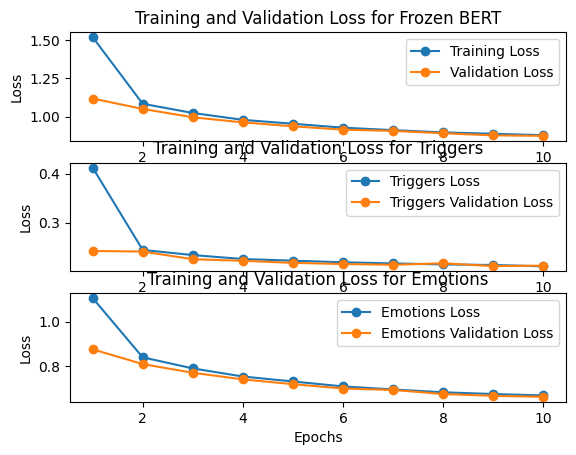

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_frozen: 0.531628194094176
Unrolled F1 score for BERT_triggers_frozen: 0.5019195797130733
Sequence F1 score for BERT_emotions_frozen: 0.4167527856765257
Unrolled F1 score for BERT_emotions_frozen: 0.3365812693575179
Unfrozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


400/400 [==============================] - 478s 1s/step - loss: 0.8676 - triggers_head_loss: 0.2240 - emotions_head_loss: 0.6436 - triggers_head_accuracy: 0.9116 - emotions_head_accuracy: 0.7893 - val_loss: 0.5668 - val_triggers_head_loss: 0.1812 - val_emotions_head_loss: 0.3856 - val_triggers_head_accuracy: 0.9189 - val_emotions_head_accuracy: 0.8763
Epoch 2/10
400/400 [==============================] - 435s 1s/step - loss: 0.4406 - triggers_head_loss: 0.1793 - emotions_head_loss: 0.2613 - triggers_head_accuracy: 0.9193 - emotions_head_accuracy: 0.9197 - val_loss: 0.3627 - val_triggers_head_loss: 0.1819 - val_emotions_head_loss: 0.1808 - val_triggers_head_accuracy: 0.9178 - val_emotions_head_accuracy: 0.9472
Epoch 3/10
400/400 [==============================] - 446s 1s/step - loss: 0.2717 - triggers_head_loss: 0.1639 - emotions_head_loss: 0.1078 - triggers_head_accuracy: 0.9229 - emotions_head_accuracy: 0.9682 - val_loss: 0.2833 - val_triggers_head_loss: 0.1743 - val_emotions_head_los

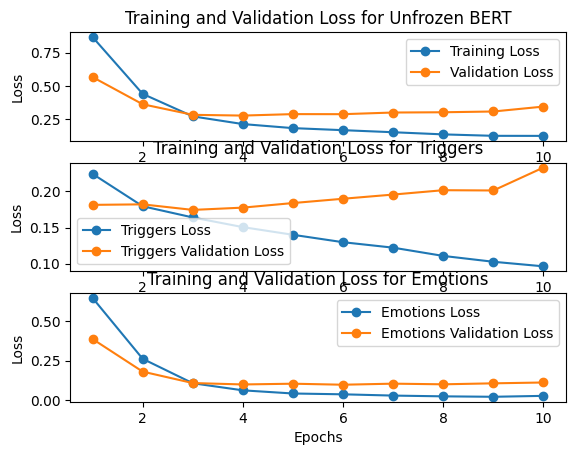

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_unfrozen: 0.6294602199349003
Unrolled F1 score for BERT_triggers_unfrozen: 0.6426306173999765
Sequence F1 score for BERT_emotions_unfrozen: 0.9207458134982819
Unrolled F1 score for BERT_emotions_unfrozen: 0.9419409191425763


In [ ]:
seed_training(1)

Seed: 2
Baseline: Class: emotions, Strategy: most_frequent
Sequence F1 score for Baseline_emotions_most_frequent: 0.18499755775534163
Unrolled F1 score for Baseline_emotions_most_frequent: 0.0871241547978708
Baseline: Class: emotions, Strategy: uniform
Sequence F1 score for Baseline_emotions_uniform: 0.09209346678453821
Unrolled F1 score for Baseline_emotions_uniform: 0.11956167237381447
Baseline: Class: triggers, Strategy: most_frequent
Sequence F1 score for Baseline_triggers_most_frequent: 0.5157037744612795
Unrolled F1 score for Baseline_triggers_most_frequent: 0.4609497032177445
Baseline: Class: triggers, Strategy: uniform
Sequence F1 score for Baseline_triggers_uniform: 0.4032442356855767
Unrolled F1 score for Baseline_triggers_uniform: 0.4299975815723442
Frozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
100/100 [==============================] - 171s 2s/step - loss: 1.4471 - triggers_head_loss: 0.3283 - emotions_head_loss: 1.1188 - triggers_head_accuracy: 0.8992 - emotions_head_accuracy: 0.6520 - val_loss: 1.1049 - val_triggers_head_loss: 0.2325 - val_emotions_head_loss: 0.8725 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.6913
Epoch 2/10
100/100 [==============================] - 170s 2s/step - loss: 1.0800 - triggers_head_loss: 0.2381 - emotions_head_loss: 0.8419 - triggers_head_accuracy: 0.9161 - emotions_head_accuracy: 0.7092 - val_loss: 1.0386 - val_triggers_head_loss: 0.2260 - val_emotions_head_loss: 0.8126 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.7169
Epoch 3/10
100/100 [==============================] - 169s 2s/step - loss: 1.0191 - triggers_head_loss: 0.2290 - emotions_head_loss: 0.7901 - triggers_head_accuracy: 0.9161 - emotions_head_accuracy: 0.7261 - val_loss: 0.9961 - val_triggers_head_loss: 0.2230 - val_emotio

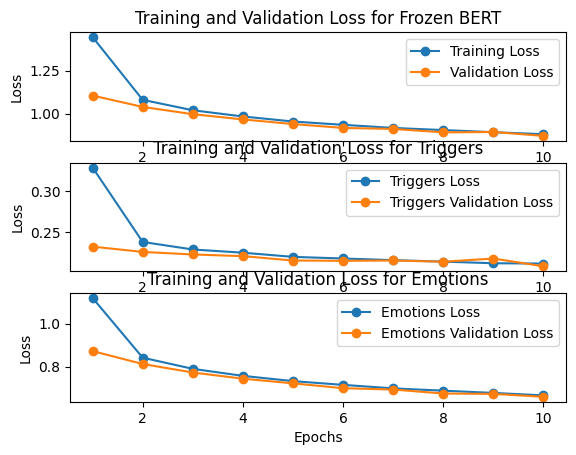

13/13 [==============================] - 20s 1s/step
Sequence F1 score for BERT_triggers_frozen: 0.5149356240232557
Unrolled F1 score for BERT_triggers_frozen: 0.46607452202451577
Sequence F1 score for BERT_emotions_frozen: 0.41218022484566874
Unrolled F1 score for BERT_emotions_frozen: 0.3409194776207484
Unfrozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


400/400 [==============================] - 464s 1s/step - loss: 0.9249 - triggers_head_loss: 0.2260 - emotions_head_loss: 0.6989 - triggers_head_accuracy: 0.9112 - emotions_head_accuracy: 0.7636 - val_loss: 0.6824 - val_triggers_head_loss: 0.1850 - val_emotions_head_loss: 0.4974 - val_triggers_head_accuracy: 0.9155 - val_emotions_head_accuracy: 0.8314
Epoch 2/10
400/400 [==============================] - 432s 1s/step - loss: 0.5427 - triggers_head_loss: 0.1822 - emotions_head_loss: 0.3605 - triggers_head_accuracy: 0.9166 - emotions_head_accuracy: 0.8839 - val_loss: 0.4320 - val_triggers_head_loss: 0.1896 - val_emotions_head_loss: 0.2424 - val_triggers_head_accuracy: 0.9175 - val_emotions_head_accuracy: 0.9259
Epoch 3/10
400/400 [==============================] - 439s 1s/step - loss: 0.3247 - triggers_head_loss: 0.1689 - emotions_head_loss: 0.1557 - triggers_head_accuracy: 0.9193 - emotions_head_accuracy: 0.9531 - val_loss: 0.3109 - val_triggers_head_loss: 0.1760 - val_emotions_head_los

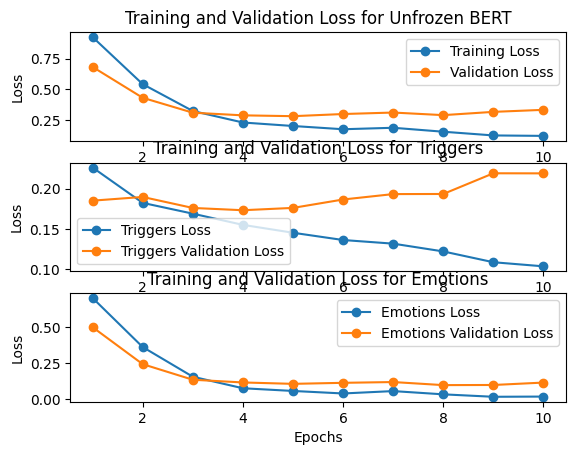

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_unfrozen: 0.6430672344569851
Unrolled F1 score for BERT_triggers_unfrozen: 0.6649056226341443
Sequence F1 score for BERT_emotions_unfrozen: 0.9293166574613528
Unrolled F1 score for BERT_emotions_unfrozen: 0.9569543063729758


In [ ]:
seed_training(2)

Seed: 3
Baseline: Class: emotions, Strategy: most_frequent
Sequence F1 score for Baseline_emotions_most_frequent: 0.18499755775534163
Unrolled F1 score for Baseline_emotions_most_frequent: 0.0871241547978708
Baseline: Class: emotions, Strategy: uniform
Sequence F1 score for Baseline_emotions_uniform: 0.0975176714819572
Unrolled F1 score for Baseline_emotions_uniform: 0.1280199377348587
Baseline: Class: triggers, Strategy: most_frequent
Sequence F1 score for Baseline_triggers_most_frequent: 0.5157037744612795
Unrolled F1 score for Baseline_triggers_most_frequent: 0.4609497032177445
Baseline: Class: triggers, Strategy: uniform
Sequence F1 score for Baseline_triggers_uniform: 0.4181721325394183
Unrolled F1 score for Baseline_triggers_uniform: 0.44641896285221483
Frozen BERT


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
100/100 [==============================] - 169s 2s/step - loss: 1.5057 - triggers_head_loss: 0.3659 - emotions_head_loss: 1.1398 - triggers_head_accuracy: 0.8934 - emotions_head_accuracy: 0.6440 - val_loss: 1.1105 - val_triggers_head_loss: 0.2339 - val_emotions_head_loss: 0.8766 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.6916
Epoch 2/10
100/100 [==============================] - 168s 2s/step - loss: 1.0874 - triggers_head_loss: 0.2399 - emotions_head_loss: 0.8475 - triggers_head_accuracy: 0.9154 - emotions_head_accuracy: 0.7074 - val_loss: 1.0305 - val_triggers_head_loss: 0.2232 - val_emotions_head_loss: 0.8073 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.7147
Epoch 3/10
100/100 [==============================] - 169s 2s/step - loss: 1.0209 - triggers_head_loss: 0.2299 - emotions_head_loss: 0.7910 - triggers_head_accuracy: 0.9156 - emotions_head_accuracy: 0.7270 - val_loss: 0.9863 - val_triggers_head_loss: 0.2199 - val_emotio

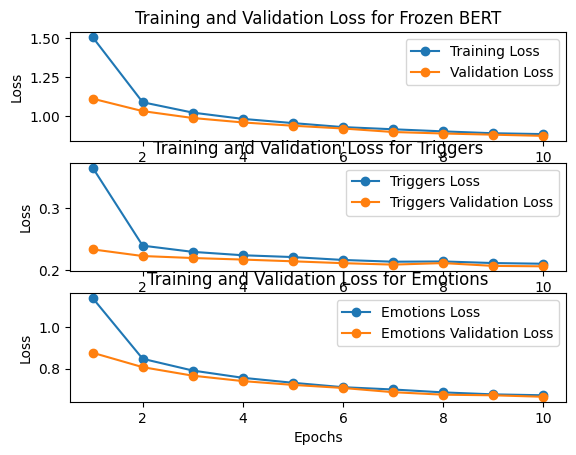

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_frozen: 0.5155170686939285
Unrolled F1 score for BERT_triggers_frozen: 0.470382055903223
Sequence F1 score for BERT_emotions_frozen: 0.40130356473342405
Unrolled F1 score for BERT_emotions_frozen: 0.3298819189377976
Unfrozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


400/400 [==============================] - 471s 1s/step - loss: 0.8387 - triggers_head_loss: 0.2187 - emotions_head_loss: 0.6199 - triggers_head_accuracy: 0.9121 - emotions_head_accuracy: 0.7941 - val_loss: 0.5696 - val_triggers_head_loss: 0.1854 - val_emotions_head_loss: 0.3842 - val_triggers_head_accuracy: 0.9170 - val_emotions_head_accuracy: 0.8727
Epoch 2/10
400/400 [==============================] - 443s 1s/step - loss: 0.4392 - triggers_head_loss: 0.1810 - emotions_head_loss: 0.2582 - triggers_head_accuracy: 0.9175 - emotions_head_accuracy: 0.9202 - val_loss: 0.3435 - val_triggers_head_loss: 0.1800 - val_emotions_head_loss: 0.1636 - val_triggers_head_accuracy: 0.9178 - val_emotions_head_accuracy: 0.9514
Epoch 3/10
400/400 [==============================] - 478s 1s/step - loss: 0.2694 - triggers_head_loss: 0.1614 - emotions_head_loss: 0.1080 - triggers_head_accuracy: 0.9241 - emotions_head_accuracy: 0.9677 - val_loss: 0.2886 - val_triggers_head_loss: 0.1762 - val_emotions_head_los

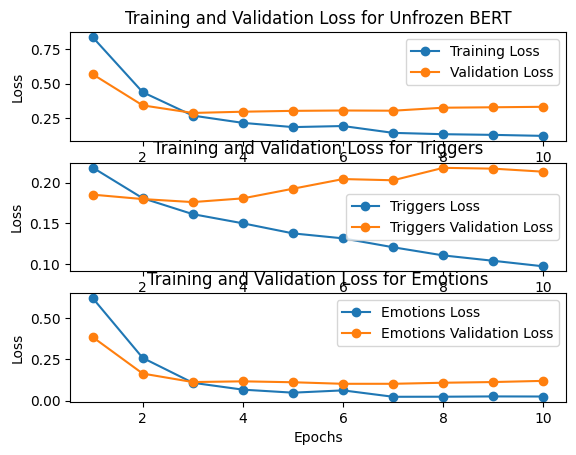

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_unfrozen: 0.5773623810340718
Unrolled F1 score for BERT_triggers_unfrozen: 0.5937311217923463
Sequence F1 score for BERT_emotions_unfrozen: 0.9154168998485597
Unrolled F1 score for BERT_emotions_unfrozen: 0.9402398590860513


In [ ]:
seed_training(3)

Seed: 4
Baseline: Class: emotions, Strategy: most_frequent
Sequence F1 score for Baseline_emotions_most_frequent: 0.18499755775534163
Unrolled F1 score for Baseline_emotions_most_frequent: 0.0871241547978708
Baseline: Class: emotions, Strategy: uniform
Sequence F1 score for Baseline_emotions_uniform: 0.08628657701425559
Unrolled F1 score for Baseline_emotions_uniform: 0.1180775464999463
Baseline: Class: triggers, Strategy: most_frequent
Sequence F1 score for Baseline_triggers_most_frequent: 0.5157037744612795
Unrolled F1 score for Baseline_triggers_most_frequent: 0.4609497032177445
Baseline: Class: triggers, Strategy: uniform
Sequence F1 score for Baseline_triggers_uniform: 0.4091446339402037
Unrolled F1 score for Baseline_triggers_uniform: 0.4292729662008442
Frozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
100/100 [==============================] - 162s 2s/step - loss: 1.6669 - triggers_head_loss: 0.4230 - emotions_head_loss: 1.2439 - triggers_head_accuracy: 0.8604 - emotions_head_accuracy: 0.6050 - val_loss: 1.1426 - val_triggers_head_loss: 0.2458 - val_emotions_head_loss: 0.8968 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.6933
Epoch 2/10
100/100 [==============================] - 165s 2s/step - loss: 1.1110 - triggers_head_loss: 0.2471 - emotions_head_loss: 0.8639 - triggers_head_accuracy: 0.9146 - emotions_head_accuracy: 0.7046 - val_loss: 1.0628 - val_triggers_head_loss: 0.2328 - val_emotions_head_loss: 0.8301 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.7133
Epoch 3/10
100/100 [==============================] - 166s 2s/step - loss: 1.0432 - triggers_head_loss: 0.2339 - emotions_head_loss: 0.8094 - triggers_head_accuracy: 0.9154 - emotions_head_accuracy: 0.7179 - val_loss: 1.0147 - val_triggers_head_loss: 0.2245 - val_emotio

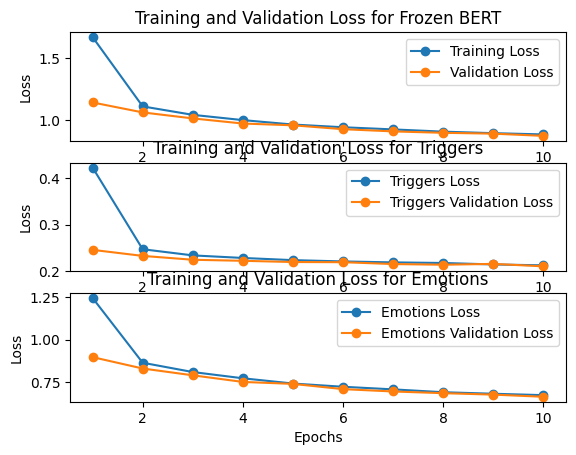

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_frozen: 0.5189600080241787
Unrolled F1 score for BERT_triggers_frozen: 0.47786058719789826
Sequence F1 score for BERT_emotions_frozen: 0.4059677342919048
Unrolled F1 score for BERT_emotions_frozen: 0.319155221443575
Unfrozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


400/400 [==============================] - 441s 1s/step - loss: 0.8309 - triggers_head_loss: 0.2176 - emotions_head_loss: 0.6133 - triggers_head_accuracy: 0.9097 - emotions_head_accuracy: 0.7982 - val_loss: 0.5586 - val_triggers_head_loss: 0.1847 - val_emotions_head_loss: 0.3739 - val_triggers_head_accuracy: 0.9144 - val_emotions_head_accuracy: 0.8838
Epoch 2/10
400/400 [==============================] - 411s 1s/step - loss: 0.4400 - triggers_head_loss: 0.1793 - emotions_head_loss: 0.2607 - triggers_head_accuracy: 0.9174 - emotions_head_accuracy: 0.9194 - val_loss: 0.3686 - val_triggers_head_loss: 0.1794 - val_emotions_head_loss: 0.1891 - val_triggers_head_accuracy: 0.9166 - val_emotions_head_accuracy: 0.9423
Epoch 3/10
400/400 [==============================] - 441s 1s/step - loss: 0.2768 - triggers_head_loss: 0.1618 - emotions_head_loss: 0.1150 - triggers_head_accuracy: 0.9228 - emotions_head_accuracy: 0.9659 - val_loss: 0.2957 - val_triggers_head_loss: 0.1713 - val_emotions_head_los

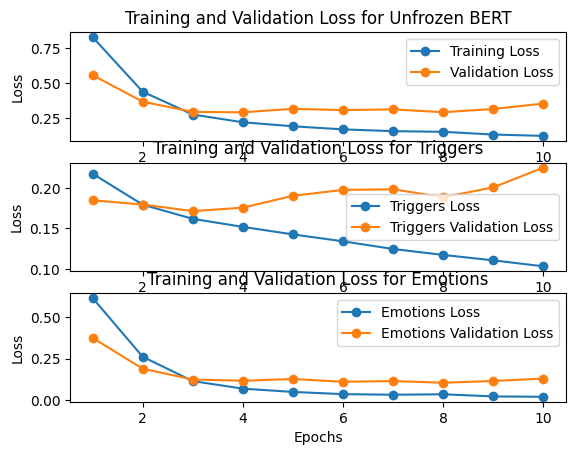

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_unfrozen: 0.658425311465781
Unrolled F1 score for BERT_triggers_unfrozen: 0.6819732910934251
Sequence F1 score for BERT_emotions_unfrozen: 0.9204348515044657
Unrolled F1 score for BERT_emotions_unfrozen: 0.9433829915301892


In [ ]:
seed_training(4)

Seed: 5
Baseline: Class: emotions, Strategy: most_frequent
Sequence F1 score for Baseline_emotions_most_frequent: 0.18499755775534163
Unrolled F1 score for Baseline_emotions_most_frequent: 0.0871241547978708
Baseline: Class: emotions, Strategy: uniform
Sequence F1 score for Baseline_emotions_uniform: 0.09980644236715666
Unrolled F1 score for Baseline_emotions_uniform: 0.12395305730822836
Baseline: Class: triggers, Strategy: most_frequent
Sequence F1 score for Baseline_triggers_most_frequent: 0.5157037744612795
Unrolled F1 score for Baseline_triggers_most_frequent: 0.4609497032177445
Baseline: Class: triggers, Strategy: uniform
Sequence F1 score for Baseline_triggers_uniform: 0.40374569648398023
Unrolled F1 score for Baseline_triggers_uniform: 0.42622688492468463
Frozen BERT


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
100/100 [==============================] - 170s 2s/step - loss: 1.5445 - triggers_head_loss: 0.3833 - emotions_head_loss: 1.1612 - triggers_head_accuracy: 0.8855 - emotions_head_accuracy: 0.6414 - val_loss: 1.1123 - val_triggers_head_loss: 0.2395 - val_emotions_head_loss: 0.8728 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.6908
Epoch 2/10
100/100 [==============================] - 166s 2s/step - loss: 1.0855 - triggers_head_loss: 0.2423 - emotions_head_loss: 0.8432 - triggers_head_accuracy: 0.9159 - emotions_head_accuracy: 0.7085 - val_loss: 1.0404 - val_triggers_head_loss: 0.2286 - val_emotions_head_loss: 0.8118 - val_triggers_head_accuracy: 0.9167 - val_emotions_head_accuracy: 0.7245
Epoch 3/10
100/100 [==============================] - 161s 2s/step - loss: 1.0263 - triggers_head_loss: 0.2335 - emotions_head_loss: 0.7928 - triggers_head_accuracy: 0.9159 - emotions_head_accuracy: 0.7247 - val_loss: 0.9902 - val_triggers_head_loss: 0.2249 - val_emotio

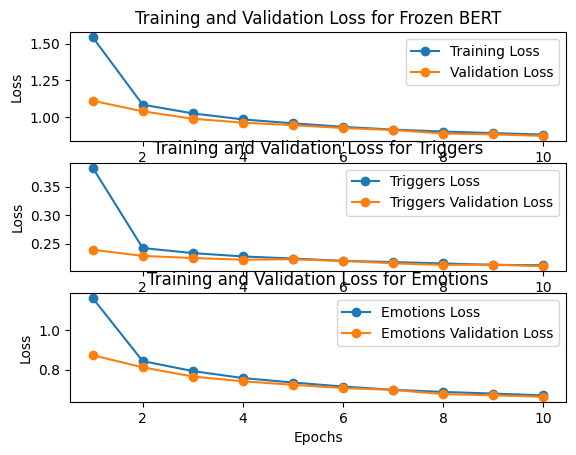

13/13 [==============================] - 18s 1s/step
Sequence F1 score for BERT_triggers_frozen: 0.5158281646252316
Unrolled F1 score for BERT_triggers_frozen: 0.4737083851080207
Sequence F1 score for BERT_emotions_frozen: 0.41468799481257873
Unrolled F1 score for BERT_emotions_frozen: 0.3336612277914065
Unfrozen BERT


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


400/400 [==============================] - 478s 1s/step - loss: 0.8531 - triggers_head_loss: 0.2240 - emotions_head_loss: 0.6291 - triggers_head_accuracy: 0.9111 - emotions_head_accuracy: 0.7914 - val_loss: 0.5841 - val_triggers_head_loss: 0.1907 - val_emotions_head_loss: 0.3934 - val_triggers_head_accuracy: 0.9130 - val_emotions_head_accuracy: 0.8744
Epoch 2/10
400/400 [==============================] - 427s 1s/step - loss: 0.4551 - triggers_head_loss: 0.1818 - emotions_head_loss: 0.2734 - triggers_head_accuracy: 0.9178 - emotions_head_accuracy: 0.9143 - val_loss: 0.3976 - val_triggers_head_loss: 0.1957 - val_emotions_head_loss: 0.2019 - val_triggers_head_accuracy: 0.9153 - val_emotions_head_accuracy: 0.9405
Epoch 3/10
400/400 [==============================] - 424s 1s/step - loss: 0.2772 - triggers_head_loss: 0.1661 - emotions_head_loss: 0.1111 - triggers_head_accuracy: 0.9222 - emotions_head_accuracy: 0.9670 - val_loss: 0.3210 - val_triggers_head_loss: 0.1875 - val_emotions_head_los

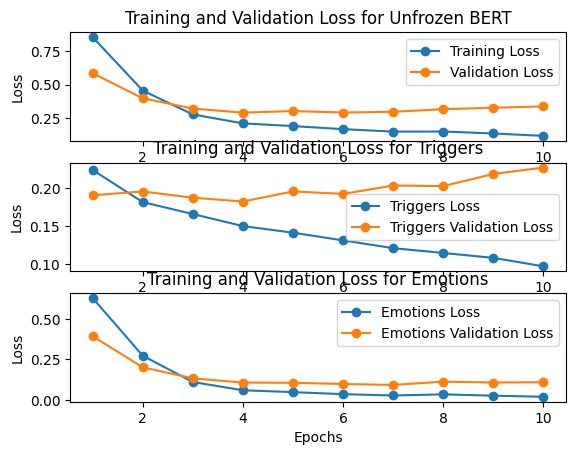

13/13 [==============================] - 19s 1s/step
Sequence F1 score for BERT_triggers_unfrozen: 0.6286166755651825
Unrolled F1 score for BERT_triggers_unfrozen: 0.6637844647305273
Sequence F1 score for BERT_emotions_unfrozen: 0.915076883190196
Unrolled F1 score for BERT_emotions_unfrozen: 0.9469770054494256


In [ ]:
seed_training(5)

### Evaluation

The training of the models is complete.
We move forward to the evaluation of the results obtained.

In the following tabel, we print the mean and st. dev. of both the Sequence F1 and the Unrolled F1, for all the models.


In [ ]:
results.compute_mean_st_dev()
results.print_results()

,Sequence F1,Unrolled F1,StDev Sequence F1,StDev Unrolled F1
Baseline_emotions_most_frequent,0.184998,0.087124,0.000000,0.000000
Baseline_emotions_uniform,0.093394,0.120788,0.004602,0.002207
Baseline_triggers_most_frequent,0.515704,0.460950,0.000000,0.000000
Baseline_triggers_uniform,0.407323,0.430308,0.005435,0.003189
BERT_triggers_frozen,0.519374,0.477989,0.006285,0.012576
BERT_emotions_frozen,0.410178,0.332040,0.005728,0.007386
BERT_triggers_unfrozen,0.627386,0.649405,0.027267,0.030506
BERT_emotions_unfrozen,0.920198,0.945899,0.005150,0.005957


The obtained results are satisfying, considering that the BERT-based models all overtake the baseline models.

Unfrozen BERT is by far the most performing model, especially for the emotion recognition task, with an Unrolled F1 score of about 0.95.

The standard deviation is not bad either, given that the worst model(BERT_triggers_unfrozen) is one order of mangnitude smaller than the mean. This shows that the results achieved are stable and consistent, across all seeds.


# Error Analysis

Even though the results we obtained were promising, we believe there could be some more work to do, in order to improve the F1 scores.

As follows, an error analysis of the two tasks conducted deploying Classification reports and Confusion matrices, over the BERT-based models.

In the table showing the results above, it is clear that the BERT-based models work much better than the baseline ones.

Now, we move forward in comparing the results obtained from the BERT-based models and, in particular, whether there is a huge difference between the `Frozen` and `Unfrozen` models.

We do that taking into account the `sklearn` built-in `classification report` and `confusion matrix`.

In [ ]:
def error_analysis(Y_true, Y_pred, padding_class, class_labels, seed, title):
  true_classes_w_padding = np.argmax(Y_true, axis=-1).flatten()
  predicted_classes_w_padding = np.argmax(Y_pred[int(seed)-1], axis=-1).flatten()

  true_classes = true_classes_w_padding[true_classes_w_padding != padding_class]
  predicted_classes = predicted_classes_w_padding[true_classes_w_padding != padding_class]

  true_classes_str = [class_labels[i] for i in true_classes]
  predicted_classes_str = [class_labels[i] for i in predicted_classes]

  cr = classification_report(true_classes_str, predicted_classes_str, labels=class_labels)
  print(f"Classification report")
  print(cr)

  cm = confusion_matrix(true_classes_str, predicted_classes_str, labels=class_labels)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot()
  plt.title(title)
  plt.show()

Given the robustness of the results, we can analyze performances only over one seed.
We chose seed = 5.

In [ ]:
seed = "5" #@param [1,2,3,4,5]

### Frozen BERT, emotions

Classification report
              precision    recall  f1-score   support

     neutral       0.65      0.89      0.75      1514
    surprise       0.69      0.46      0.55       474
        fear       0.00      0.00      0.00       109
     sadness       0.48      0.06      0.11       252
         joy       0.57      0.53      0.55       647
     disgust       0.00      0.00      0.00       101
       anger       0.36      0.41      0.38       354

    accuracy                           0.60      3451
   macro avg       0.39      0.34      0.33      3451
weighted avg       0.56      0.60      0.55      3451



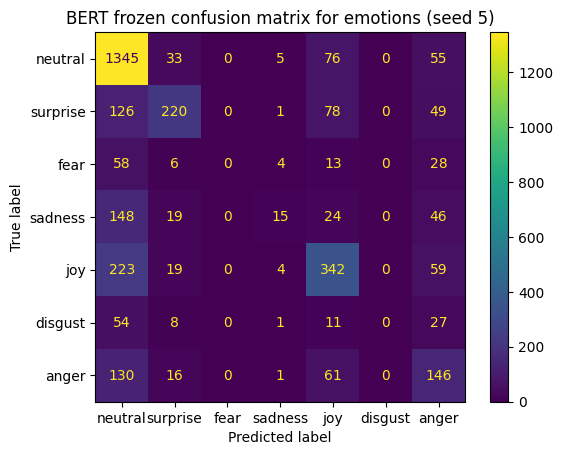

In [ ]:
error_analysis(Y_test_emotions,results.y_pred['BERT_emotions_frozen'],EMOTIONS_PAD,emotions_classes, seed, f"BERT frozen confusion matrix for emotions (seed {seed})")

From both the Classification report and the Confusion matrix above, we can see that the worst performing classes are fear and disgust, since they both have 0.0 in precision, recall and F1-score. Apart from those, the class that performs the worst is sadness, with an F1-score of 0.11.
The report also shows a correlation between class performance and class support, due to the high unbalance of the dataset, especially on the neutral class, which is the one that performs the best.

Analyzing the confusion matrix, it stands out how the most well predicted classes are the three most represented by the data set. The predicted neutral class is often confused with joy class, the first and second most represented classes. Apart from the neutral class, the most confused class is joy, and very often with surprise.
This is an unwanted result but not so 'odd', given that joy and suprise are emotions that can be easily confused even by a human, since they can be both triggered in similar contexts.

### Unfrozen BERT, emotions

Classification report
              precision    recall  f1-score   support

     neutral       0.99      0.97      0.98      1514
    surprise       0.97      0.96      0.96       474
        fear       0.97      0.91      0.94       109
     sadness       0.86      0.96      0.91       252
         joy       0.95      0.96      0.96       647
     disgust       0.98      0.93      0.95       101
       anger       0.91      0.94      0.93       354

    accuracy                           0.96      3451
   macro avg       0.95      0.95      0.95      3451
weighted avg       0.96      0.96      0.96      3451



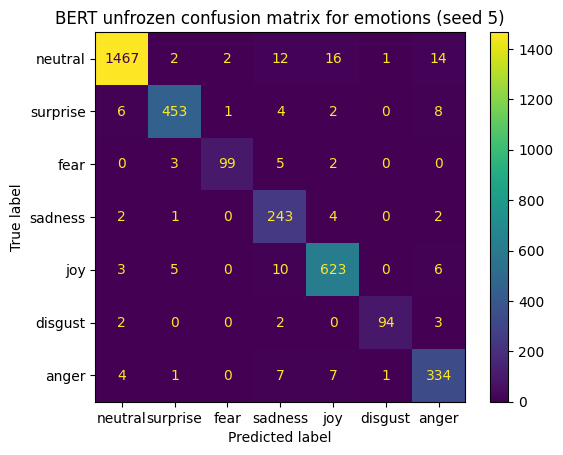

In [ ]:
error_analysis(Y_test_emotions,results.y_pred['BERT_emotions_unfrozen'],EMOTIONS_PAD,emotions_classes, seed, f"BERT unfrozen confusion matrix for emotions (seed {seed})")

As already introduced before in the results table, the Emotions recognition task performed by the Unforzen BERT model gives the most satisfying results.
All the classes do an excellent job even if the dataset in unbalanced.
The high performances are supported by the fact that the worst performing class is sadness, with an F1-score of 0.91, and lacking a bit on precision (0.86).

Taking a look at the confusion matrix, it's clear that the most confused class is neutral with joy, just like before. Apart from neutral, that again, is the most skewed class, the most confused class is joy with sadness, but the confusion is very little in comparison with the overall cases.

It is important to notice that, after unfreezing BERT, both performances in terms of metrics and confusion between classes remarkably improve.

### Frozen BERT, triggers

Classification report
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92      2951
         1.0       0.33      0.01      0.03       500

    accuracy                           0.85      3451
   macro avg       0.59      0.50      0.47      3451
weighted avg       0.78      0.85      0.79      3451



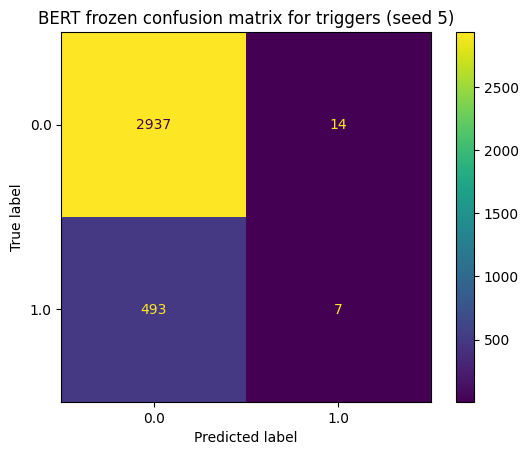

In [ ]:
error_analysis(Y_test_triggers,results.y_pred['BERT_triggers_frozen'],TRIGGERS_PAD,triggers_classes, seed, f"BERT frozen confusion matrix for triggers (seed {seed})")

### Unfrozen BERT, triggers

Classification report
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      2951
         1.0       0.45      0.39      0.42       500

    accuracy                           0.84      3451
   macro avg       0.67      0.66      0.66      3451
weighted avg       0.83      0.84      0.84      3451



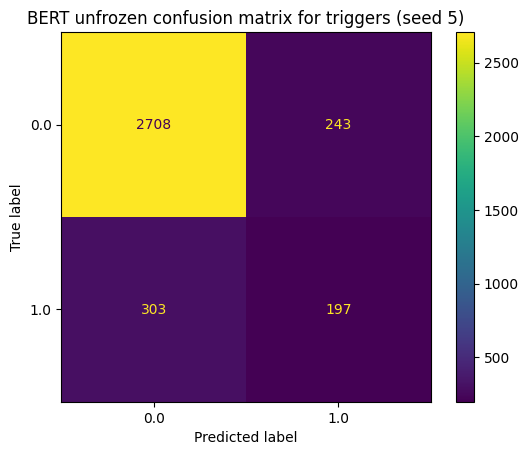

In [ ]:
error_analysis(Y_test_triggers,results.y_pred['BERT_triggers_unfrozen'],TRIGGERS_PAD,triggers_classes, seed, f"BERT unfrozen confusion matrix for triggers (seed {seed})")

An error analysis solely on the triggers classification is straighforward. In fact, both the models don't perform optimally, due to the high unbalance of the dataset, deepely skewed towards the negative triggers.
Being only two the classes of the triggers, a 'classwise' analysis as we did for emotions can't be carried out.
Though, a comparison can be drawn between the two models, since the unfrozen model performs much better even with few positive triggers examples, predicting correctly more than 50% of the positive triggers.

As the confusion matrix suggests for both models, the most confused case is predicting the value of 0.0 instead of 1.0, plausible due to high dataset unbalance.

# Conclusion

As we conducted the projected, we incurred a few challenges, which helped us improve our way of working and deepened our knowledge.

Facing hyperparameters tuning, especially starting from a baseline of values found with the KerasTuner, made us realize even further how important the number of activations and the Dropout rates are, which drastically changed the behavior of the models' training. Using the KerasTuner represented a good starting point, but it was fundamental to iterate and perform tests in order to obtain the best values possible, with the resources at our disposal.

Finally, the huge difference between the results obtained from the two BERT-based models showed how important it can be for a model to have a strong backbone, trained together with the rest of the model. Our previous beliefs were that it would have taken too much time to train the Full model, but after our work, we changed our mind, seeing that, of course it takes longer that the Frozen version, but it's not so expensive.

Thus, for a further improvement of the results we obtained, the best choice would be to use the Unfrozen model, with a slight improvement of the Triggers classification head.